### Load VBR Dataset and calibration parameters

In [1]:
### LOAD DATASET AND CALIBRATION FILE 

from my_utils.my_vbr_dataset import vbrDataset, load_calibration, generate_depth_and_scene_maps
from my_utils.mast3r_utils import get_master_output, get_mast3r_image_shape, scale_intrinsics, overlap
import cv2

dataset = vbrDataset(
    '/datasets/vbr_slam/spagna/spagna_train0_kitti', #path to dataset in kitti format
    '/datasets/vbr_slam/spagna/spagna_train0/spagna_train0_gt.txt' #path to ground truth file
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import defaultdict

from my_utils.plotting import load_pose_results, plot_all_estimates_for_query

# -- Load pose estimates --
mast3r_rows = load_pose_results("results2/spagna_mast3r.txt")
lidar_rows            = load_pose_results("results2/spagna_lidar.txt")
mast3r_scaled_v3_rows = load_pose_results("results2/spagna_mast3r_scaled_v3.txt")
mast3r_scaled_v4_rows = load_pose_results("results2/spagna_mast3r_scaled_v4.txt")
mast3r_scaled_icp_rows = load_pose_results("results2/spagna_mast3r_scaled_icp.txt")  # NEW

# -- Group rows by query index --
def group_by_query(rows):
    d = defaultdict(list)
    for row in rows:
        query_idx, anchor_idx = int(row[0]), int(row[1])
        d[query_idx].append((anchor_idx, row[2:]))
    return d

mast3r_by_query        = group_by_query(mast3r_rows)
lidar_by_query         = group_by_query(lidar_rows)
mast3r_scaled_v3_query = group_by_query(mast3r_scaled_v3_rows)
mast3r_scaled_v4_query = group_by_query(mast3r_scaled_v4_rows)
mast3r_scaled_icp_query = group_by_query(mast3r_scaled_icp_rows)  # NEW

# -- Define styles for each result type --
styles = {
    "MASt3R":      {'anchor': 'black', 'estimate': 'blue'},
    "LiDAR":       {'anchor': 'black', 'estimate': 'red'},
    "Scaled V3":   {'anchor': 'black', 'estimate': 'cyan'},
    "Scaled V4":   {'anchor': 'black', 'estimate': 'brown'},
    "Scaled V5":  {'anchor': 'black', 'estimate': 'orange'},  # NEW
}

all_results_dicts = {
    "MASt3R":      (mast3r_by_query, styles["MASt3R"]),
    "LiDAR":       (lidar_by_query, styles["LiDAR"]),
    "Scaled V3":   (mast3r_scaled_v3_query, styles["Scaled V3"]),
    "Scaled V4":   (mast3r_scaled_v4_query, styles["Scaled V4"]),
    "Scaled V5":  (mast3r_scaled_icp_query, styles["Scaled V5"]),  # NEW
}

# -- UI setup --
unique_queries = sorted(mast3r_by_query.keys())
query_slider = widgets.SelectionSlider(
    options=unique_queries,
    description="Query idx",
    layout=widgets.Layout(width='90%')
)
result_types = list(all_results_dicts.keys())
result_selector = widgets.SelectMultiple(
    options=result_types,
    value=tuple(result_types),
    description="Results",
    layout=widgets.Layout(width='50%')
)
out = widgets.Output()

def plot_query_estimates_modular(query_idx, selected_results):
    with out:
        clear_output(wait=True)
        # Only include selected result types
        selected_dicts = {k: all_results_dicts[k] for k in selected_results}
        plot_all_estimates_for_query(query_idx, dataset, selected_dicts, styles)

def on_change(change):
    plot_query_estimates_modular(query_slider.value, result_selector.value)

query_slider.observe(lambda change: on_change(change), names='value')
result_selector.observe(lambda change: on_change(change), names='value')

display(widgets.HBox([query_slider, result_selector]), out)
plot_query_estimates_modular(query_slider.value, result_selector.value)

Output()

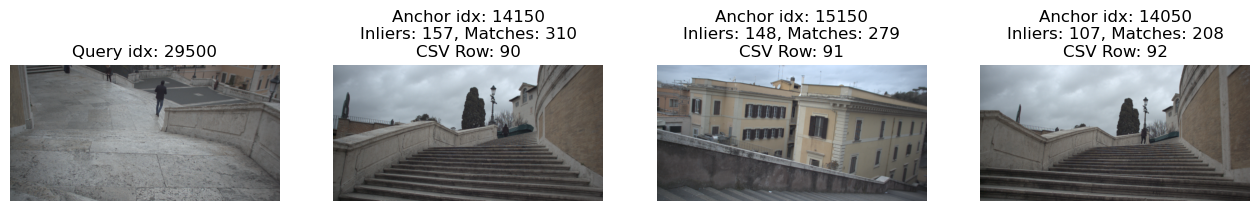

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Load CSV with top3 anchors per query
top3_df = pd.read_csv('results2/spagna_matches_inliers_fm_top3.csv')

def show_images_for_query(query_idx):
    # Display query image
    query_data = dataset[query_idx]
    query_img = Image.open(query_data['image_left'])

    # Get top 3 anchors for this query
    anchors_for_query = top3_df[top3_df['query_idx'] == query_idx].sort_values('num_inliers', ascending=False).head(3)
    n_anchors = len(anchors_for_query)

    fig, axs = plt.subplots(1, n_anchors + 1, figsize=(4*(n_anchors+1), 4))
    axs = np.array(axs).flatten() if n_anchors > 0 else [axs]

    # Show query image
    axs[0].imshow(query_img)
    axs[0].set_title(f"Query idx: {query_idx}")
    axs[0].axis('off')

    # Show anchor images (if any)
    for i, (_, row) in enumerate(anchors_for_query.iterrows()):
        anchor_idx = row['anchor_idx']
        anchor_data = dataset[anchor_idx]
        anchor_img = Image.open(anchor_data['image_left'])
        csv_row_index = anchors_for_query.index[i]
        axs[i+1].imshow(anchor_img)
        axs[i+1].set_title(f"Anchor idx: {anchor_idx}\nInliers: {row['num_inliers']}, Matches: {row['num_matches']}\nCSV Row: {csv_row_index}")
        axs[i+1].axis('off')

    plt.show()

# Example usage:
query_idx = 29500 # Change this to the query index you want
show_images_for_query(query_idx)

In [7]:
!find . -iname "*inspect_results*.ipynb"